## Creating normalized database

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import sqlite3

conn = sqlite3.connect('titanic.db')
cursor = conn.cursor()

In [ ]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS Passengers (
  name TEXT,
  sex TEXT,
  age REAL
  )
  """
)

cursor.execute("""
CREATE TABLE IF NOT EXISTS Journey (
  name TEXT,
  ticket TEXT,
  pclass INTEGER,
  sibsp INTEGER,
  parch INTEGER,
  fare REAL,
  cabin TEXT,
  embarked TEXT,
  survived INTEGER,
  boat TEXT,
  body TEXT,
  PRIMARY KEY (name, ticket),
  FOREIGN KEY (name) REFERENCES Passengers(name)
  )
""")

conn.commit()

In [ ]:
import csv

# Function to insert data into Passengers table
def insert_passenger_data(name, sex, age):
    cursor.execute('INSERT OR IGNORE INTO Passengers (name, sex, age) VALUES (?, ?, ?)',
              (name, sex, None if age == '' else float(age)))
    conn.commit()

# Function to insert data into Journey table
def insert_journey_data(name, ticket, pclass, sibsp, parch, fare, cabin, embarked, survived, boat, body):
    cursor.execute('INSERT INTO Journey (name, ticket, pclass, sibsp, parch, fare, cabin, embarked, survived, boat, body) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)',
              (name, ticket, None if pclass == '' else int(pclass),
               None if sibsp == '' else int(sibsp),
               None if parch == '' else int(parch),
               None if fare == '' else float(fare),
               cabin, embarked,
               None if survived == '' else int(survived),
               boat, body))
    conn.commit()

In [ ]:
with open('titanic3.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        insert_passenger_data(row['name'], row['sex'], row['age'])
        insert_journey_data(row['name'], row['ticket'], row['pclass'], row['sibsp'],
                       row['parch'], row['fare'], row['cabin'], row['embarked'],
                       row['survived'], row['boat'], row['body'])
conn.close()

opens a conn to a sqlite db    
create a table called stocks     
using the csv file insert_data function tries to insert the values and the values that are empty strings in csv file are converted to ' NONE'

## Data pre-processing

In [ ]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('titanic.db')

query = '''
SELECT p.name, p.sex, p.age, j.ticket, j.pclass, j.sibsp, j.parch, j.fare, j.cabin, j.embarked, j.survived, j.boat, j.body
FROM Passengers p
JOIN Journey j ON p.name = j.name
'''

data = pd.read_sql_query(query, conn)
conn.close()

In [ ]:
print(data['survived'].value_counts())

survived
0    812
1    501
Name: count, dtype: int64


it seems that data is imbalanced, so lets balance the data

In [ ]:
#Separating the data
a = data[data['survived'] == 0]
b = data[data['survived'] == 1]

In [ ]:
A = a.sample(n = 501)

In [ ]:
#Concatenating 2 dataframes(legit_sample , fraud)
data = pd.concat([A, b], axis = 0)
data.head()

,name,sex,age,ticket,pclass,sibsp,parch,fare,cabin,embarked,survived,boat,body
769,"Demetri, Mr. Marinko",male,NaN,349238,3,0,0,7.8958,,S,0,,
40,"Brewe, Dr. Arthur Jackson",male,NaN,112379,1,0,0,39.6000,,C,0,,
1207,"Sivic, Mr. Husein",male,40.0,349251,3,0,0,7.8958,,S,0,,
581,"Watson, Mr. Ennis Hastings",male,NaN,239856,2,0,0,0.0000,,S,0,,
921,"Katavelas, Mr. Vassilios (""Catavelas Vassilios"")",male,18.5,2682,3,0,0,7.2292,,C,0,,58


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1002 entries, 769 to 1304
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      1002 non-null   object 
 1   sex       1002 non-null   object 
 2   age       813 non-null    float64
 3   ticket    1002 non-null   object 
 4   pclass    1002 non-null   int64  
 5   sibsp     1002 non-null   int64  
 6   parch     1002 non-null   int64  
 7   fare      1002 non-null   float64
 8   cabin     1002 non-null   object 
 9   embarked  1002 non-null   object 
 10  survived  1002 non-null   int64  
 11  boat      1002 non-null   object 
 12  body      1002 non-null   object 
dtypes: float64(2), int64(4), object(7)
memory usage: 109.6+ KB


In [ ]:
data.describe()

,age,pclass,sibsp,parch,fare,survived
count,813.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.00000
mean,29.508713,2.226547,0.468064,0.388224,36.753189,0.50000
std,14.221357,0.857228,0.951091,0.821770,56.355136,0.50025
min,0.166700,1.000000,0.000000,0.000000,0.000000,0.00000
25%,21.000000,1.000000,0.000000,0.000000,7.925000,0.00000
50%,28.000000,3.000000,0.000000,0.000000,15.500000,0.50000
75%,38.000000,3.000000,1.000000,0.000000,35.500000,1.00000
max,80.000000,3.000000,8.000000,9.000000,512.329200,1.00000


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
print(train.groupby('sex').size())

sex
female    323
male      478
dtype: int64


In [ ]:
train['sex'] = train['sex'].replace({'male': 0, 'female': 1})

In [ ]:
train.head()

,name,sex,age,ticket,pclass,sibsp,parch,fare,cabin,embarked,survived,boat,body
54,"Carter, Master. William Thornton II",0,11.0,113760,1,1,2,120.0000,B96 B98,S,1,4,
317,"Williams, Mr. Richard Norris II",0,21.0,PC 17597,1,0,1,61.3792,,C,1,A,
87,"Daniel, Mr. Robert Williams",0,27.0,113804,1,0,0,30.5000,,S,1,3,
229,"Penasco y Castellana, Mrs. Victor de Satode (M...",1,17.0,PC 17758,1,1,0,108.9000,C65,C,1,8,
144,"Harder, Mrs. George Achilles (Dorothy Annan)",1,25.0,11765,1,1,0,55.4417,E50,C,1,5,


In [ ]:
train.drop(['name', 'ticket'], axis=1, inplace=True)

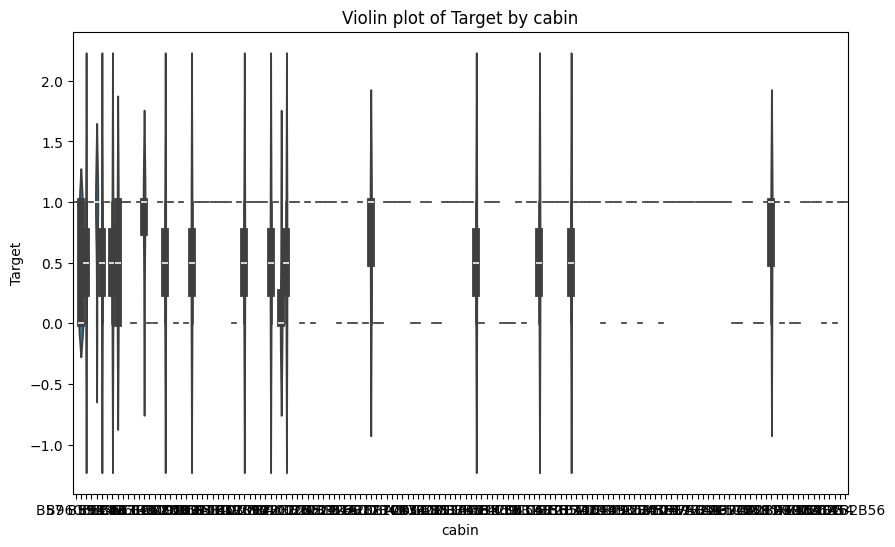

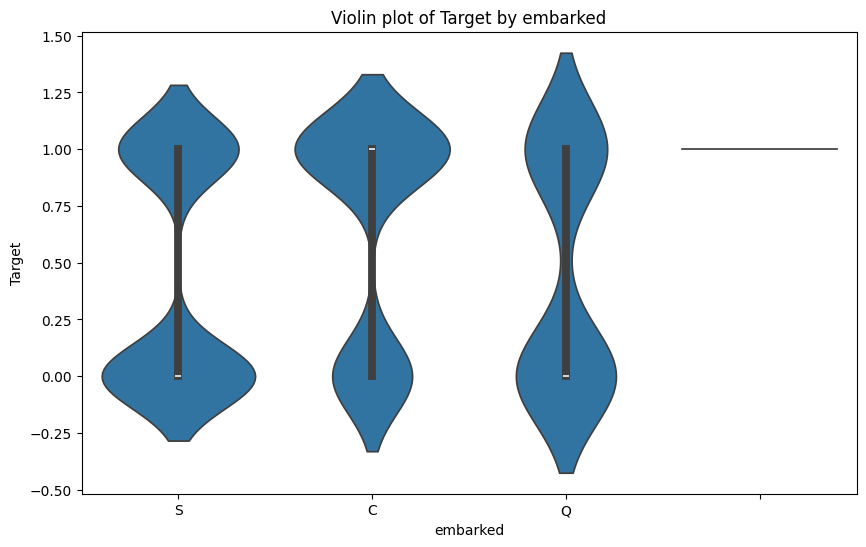

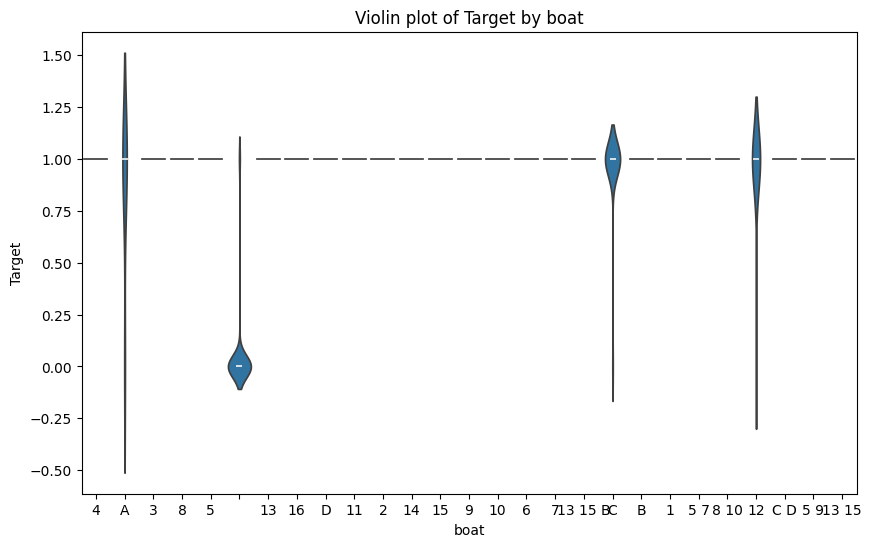

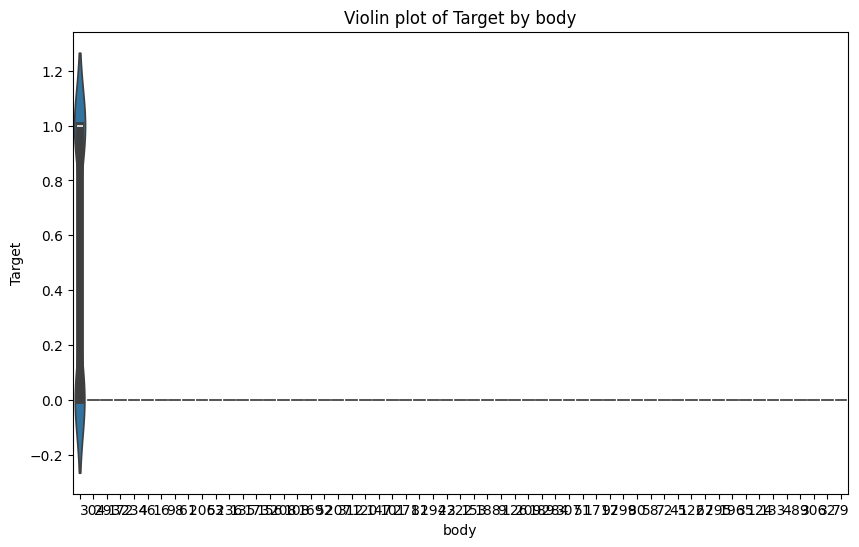

In [ ]:
categories = ['cabin','embarked','boat', 'body']

# Create a violin plot for each categorical feature
for category in categories:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x=category, y=train['survived'], data=train)
    plt.title(f'Violin plot of Target by {category}')
    plt.xlabel(category)
    plt.ylabel('Target')
    plt.show()

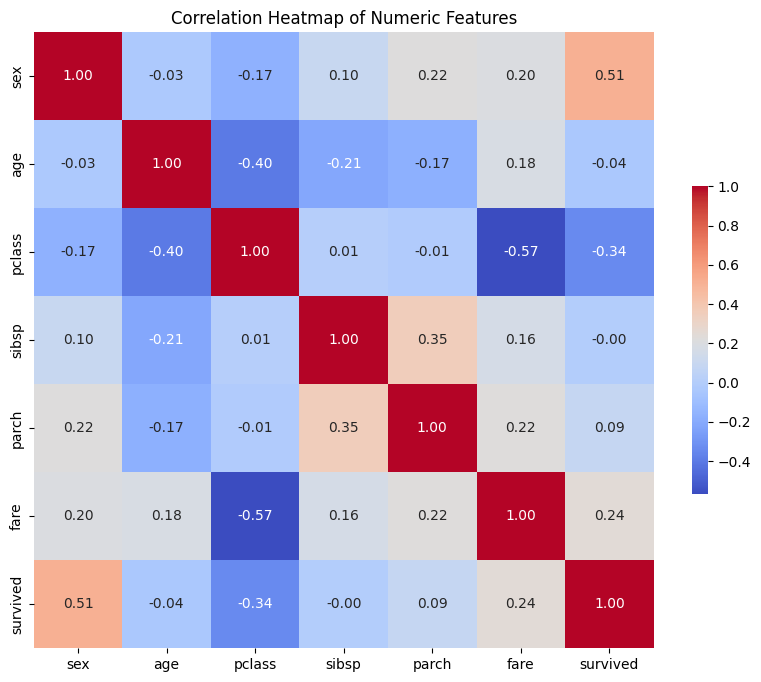

In [ ]:
import numpy as np
numeric_df = data.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


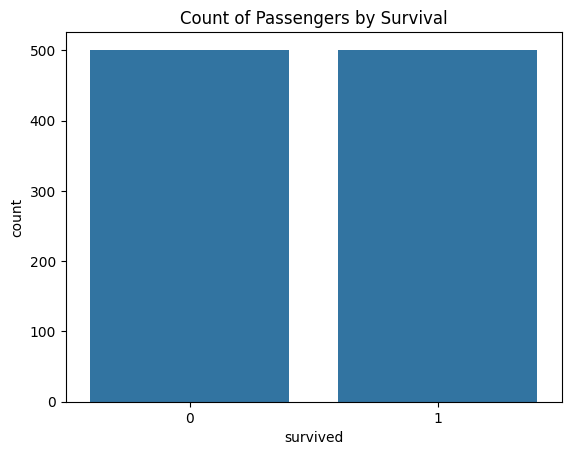

In [ ]:
# Create a countplot of the target variable
sns.countplot(x='survived', data=data)
plt.title('Count of Passengers by Survival')
plt.show()

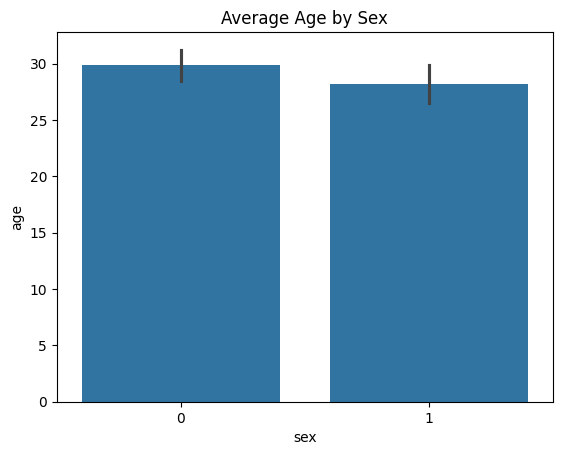

In [ ]:
# Create a bar chart of the average age by sex
sns.barplot(x='sex', y='age', data=train)
plt.title('Average Age by Sex')
plt.show()

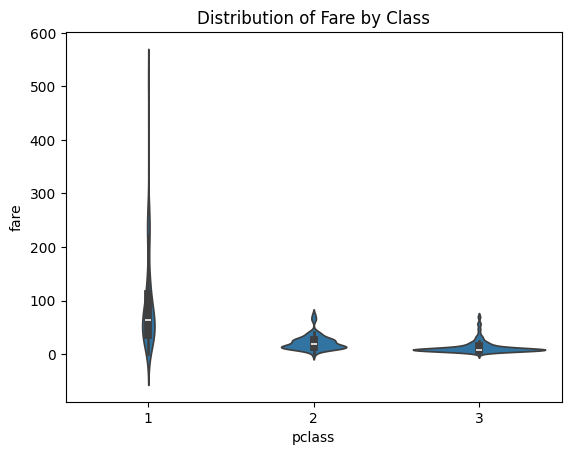

In [ ]:
# Create a violin plot of the fare by class
sns.violinplot(x='pclass', y='fare', data=train)
plt.title('Distribution of Fare by Class')
plt.show()

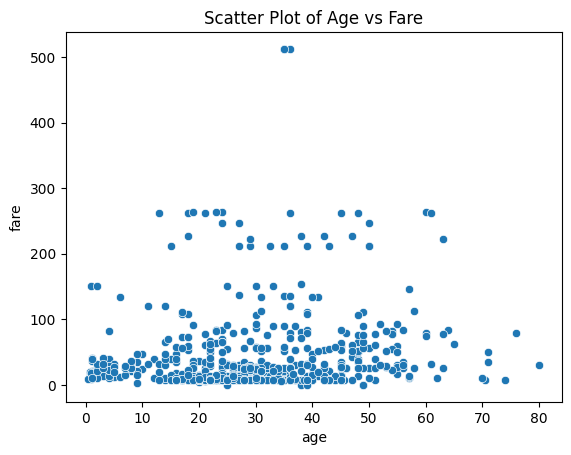

In [ ]:
# Create a scatter plot of the age and fare
sns.scatterplot(x='age', y='fare', data=train)
plt.title('Scatter Plot of Age vs Fare')
plt.show()

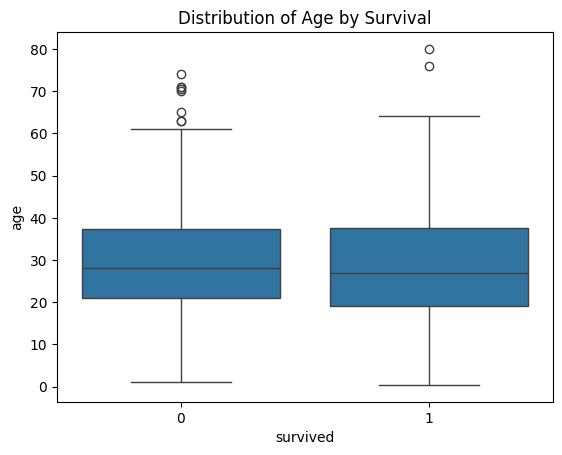

In [ ]:
# Create a boxplot of the age by survival
sns.boxplot(x='survived', y='age', data=train)
plt.title('Distribution of Age by Survival')
plt.show()

## EDA

In [ ]:
# Identify input and target columns
x = train.drop(['survived'], axis=1)
y = train['survived']

In [ ]:
# separate numeric and categorical columns
import numpy as np
numeric = x.select_dtypes(include=np.number).columns.tolist()
categorical = x.select_dtypes('object').columns.tolist()

In [ ]:
# checking missing values in numeric columns
x[numeric].isna().sum()

sex         0
age       150
pclass      0
sibsp       0
parch       0
fare        0
dtype: int64

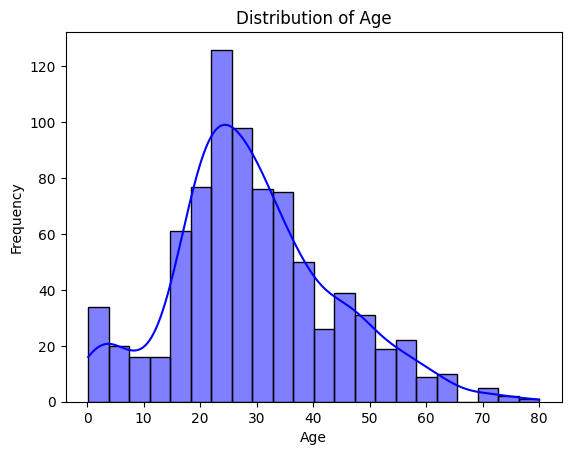

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_df is your DataFrame containing the 'age' column.
sns.histplot(data['age'].dropna(), kde=True, color='blue')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
mean_age = x['age'].mean()
x['age'].fillna(mean_age, inplace=True)

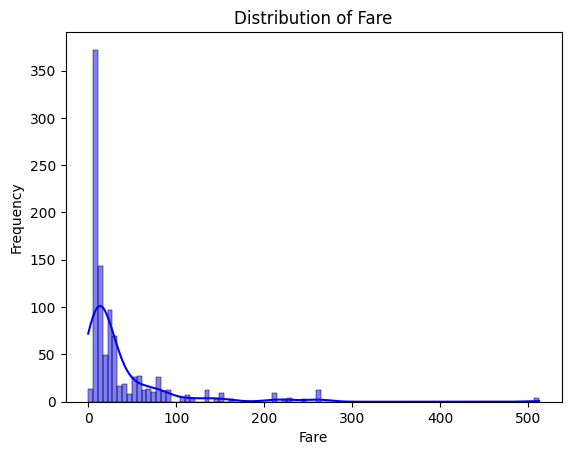

In [ ]:
sns.histplot(data['fare'].dropna(), kde=True, color='blue')
plt.title('Distribution of Fare')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.show()

In [ ]:
x['fare'].fillna(x['fare'].mean(), inplace=True)

In [ ]:
x[numeric].isna().sum()

sex       0
age       0
pclass    0
sibsp     0
parch     0
fare      0
dtype: int64

In [ ]:
# checking missing values in categorical columns
x[categorical].isna().sum()

cabin       0
embarked    0
boat        0
body        0
dtype: int64

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(x[categorical])
encoded_cols = encoder.get_feature_names_out(categorical)
encoded_df = pd.DataFrame(encoder.transform(x[categorical]), columns=encoded_cols, index=x.index)
x = pd.concat([x, encoded_df], axis=1)
x.drop(columns=categorical, inplace=True)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Normalizing the data
x.describe().loc[['min', 'max']]

,sex,age,pclass,sibsp,parch,fare,cabin_,cabin_A11,cabin_A14,cabin_A16,...,body_61,body_67,body_72,body_79,body_80,body_81,body_89,body_9,body_97,body_98
min,0.0,0.4167,1.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,80.0000,3.0,8.0,9.0,512.3292,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
from sklearn import preprocessing
X = preprocessing.normalize(X, norm='l1')

In [ ]:
# Splitting the dataset into train and test
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(640, 476)
(640,)
(161, 476)
(161,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(X_train)
x_test = scaler.transform(X_test)

## Model Training and Optimization

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
models=[]
results=[]
names=[]

In [ ]:
models.append(('LR',LogisticRegression()))
models.append(('RFC',RandomForestClassifier()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('DTC',DecisionTreeClassifier()))
models.append(('XGB',XGBClassifier()))
models.append(('NB',GaussianNB()))
models.append(('SVM',SVC()))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Create the pipeline
results = {}
for name, model in models:
    pipeline = Pipeline([
        ('classifier', model)  # Each model is a step in the pipeline
    ])

    # Fit the model
    pipeline.fit(x_train, y_train)

    # Evaluate the model
    y_pred = pipeline.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)

    results[name] = {
        'accuracy': accuracy,
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

In [ ]:
model_accuracies = []

for name, result in results.items():
    model_accuracies.append((name, result['accuracy']))

model_accuracies.sort(key=lambda x: x[1], reverse=True)

top_models = model_accuracies[:3]
for i, (name, accuracy) in enumerate(top_models, start=1):
    print(f"Top {i} Model: {name} ; Accuracy: {accuracy:.2f}")


Top 1 Model: LR ; Accuracy: 0.98
Top 2 Model: RFC ; Accuracy: 0.98
Top 3 Model: DTC ; Accuracy: 0.98


In [ ]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, precision_score,
    recall_score, roc_auc_score, classification_report, confusion_matrix
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
import numpy as np

# Assuming 'models' is a list of (name, model) tuples and x_train, y_train, x_test, y_test are defined
results = {}
for name, model in models:
    pipeline = Pipeline([
        ('classifier', model)
    ])

    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)

    try:
        y_proba = pipeline.predict_proba(x_test)
    except AttributeError:
        y_proba = None

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred, average='weighted'),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred).tolist()
    }

    if y_proba is not None:
        if y_test.nunique() == 2:
            metrics['roc_auc_score'] = roc_auc_score(y_test, y_proba[:, 1])
        else:
            y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))
            metrics['roc_auc_score'] = roc_auc_score(y_test_binarized, y_proba, multi_class='ovr')
    else:
        metrics['roc_auc_score'] = 'N/A'

    results[name] = metrics

# Sort and print the top three models
model_accuracies = [(name, result['accuracy']) for name, result in results.items()]
model_accuracies.sort(key=lambda x: x[1], reverse=True)
top_models = model_accuracies[:3]

for i, (name, accuracy) in enumerate(top_models, start=1):
    result = results[name]
    print(f"Top {i} Model: {name}")
    print(f"Accuracy: {result['accuracy']:.2f}")
    print("Classification Report:")
    print(result['classification_report'])
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    print("\n" + "-"*50 + "\n")


Top 1 Model: RFC
Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        84
           1       0.99      0.99      0.99        77

    accuracy                           0.99       161
   macro avg       0.99      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161

Confusion Matrix:
[[83, 1], [1, 76]]

--------------------------------------------------

Top 2 Model: LR
Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        84
           1       0.99      0.97      0.98        77

    accuracy                           0.98       161
   macro avg       0.98      0.98      0.98       161
weighted avg       0.98      0.98      0.98       161

Confusion Matrix:
[[83, 1], [2, 75]]

--------------------------------------------------

Top 3 Model: DTC
Accuracy: 0.98
Classification Report:
  

### Hyperparameter Tuning


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [3, 5, 7, None],     # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required to be at a leaf node
}

# Initialize Random Forest Classifier
clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_  # This is directly the accuracy because we're using 'accuracy' as the scoring parameter

print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)

Best Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Accuracy: 0.978125


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to tune for Decision Tree
param_grid_dtc = {
    'max_depth': [3, 5, 7, None],     # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required to be at a leaf node
}

# Initialize Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV for Decision Tree
grid_search_dtc = GridSearchCV(estimator=dtc, param_grid=param_grid_dtc, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dtc.fit(x_train, y_train)

# Get the best parameters and score for Decision Tree
best_params_dtc = grid_search_dtc.best_params_
best_score_dtc = grid_search_dtc.best_score_

print("Decision Tree - Best Parameters:", best_params_dtc)
print("Decision Tree - Best Accuracy:", best_score_dtc)

Decision Tree - Best Parameters: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Decision Tree - Best Accuracy: 0.978125


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to tune for SVM
param_grid_svm = {
    'C': [0.1, 1, 10],                # Regularization parameter
    'kernel': ['linear', 'rbf'],      # Type of SVM kernel
    'gamma': ['scale', 'auto']        # Kernel coefficient
}

# Initialize Support Vector Machine Classifier
svm = SVC(random_state=42)

# Initialize GridSearchCV for SVM
grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(x_train, y_train)

# Get the best parameters and score for SVM
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_

print("SVM - Best Parameters:", best_params_svm)
print("SVM - Best Accuracy:", best_score_svm)

SVM - Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
SVM - Best Accuracy: 0.978125


In [ ]:
# Define the model
model = LogisticRegression()

# Define the hyperparameter grid to search
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-4, 4, 20),  # Wide range of the regularization hyperparameter
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'],
    'max_iter': [100, 500, 1000],
    'class_weight': [None, 'balanced']
}

# Setup the grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=True, scoring='accuracy')

# Perform the grid search
grid_search.fit(x_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_

## Dagshub

In [52]:
import dagshub
dagshub.init(repo_owner='rithwik.g.misc', repo_name='Titanic', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=ac9d739b-c027-471e-ba88-71f40900d901&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=053ec79a6f7d92e0caea82dec710ba79179edffc1f1e6e2b238501418cf761a4




Initialized MLflow to track repo "rithwik.g.misc/Titanic"

Repository rithwik.g.misc/Titanic initialized!

In [ ]:
import mlflow
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Configure MLflow - This initializes MLflow tracking
mlflow.set_tracking_uri("file:///path_to_your_mlruns_folder")  # Modify as needed
mlflow.set_experiment("Titanic Survival Prediction")

# Define the models and parameters for GridSearchCV
models = [
    ("LR", LogisticRegression()),
    ("RFC", RandomForestClassifier()),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier()),
    ("XGB", XGBClassifier()),
    ("NB", GaussianNB()),
    ("SVM", SVC())
]

param_grids = {
    "LR": {'penalty': ['l2'], 'C': np.logspace(-4, 4, 20), 'solver': ['liblinear']},
    "RFC": {'n_estimators': [100, 200], 'max_depth': [3, 5, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]},
    "KNN": {},
    "DTC": {'max_depth': [3, 5, 7, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
    "XGB": {'learning_rate': [0.01, 0.1], 'n_estimators': [100, 200], 'subsample': [0.5, 0.7]},
    "NB": {},
    "SVM": {'C': [0.1, 1, 10], 'kernel': ['rbf'], 'gamma': ['scale', 'auto']}
}

for name, model in models:
    with mlflow.start_run(run_name=name):
        # Use GridSearchCV to find the best parameters for the model
        grid_search = GridSearchCV(estimator=model, param_grid=param_grids.get(name, {}), cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Best model
        best_model = grid_search.best_estimator_

        # Predictions
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

        # Log parameters, metrics, and model
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        if auc:
            mlflow.log_metric("auc", auc)

        mlflow.sklearn.log_model(best_model, "model")

        mlflow.end_run()
